<a href="https://colab.research.google.com/github/Mael-zys/IMA207/blob/main/TP3_IMA207_yangsong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tempfile
import os
import matplotlib.pyplot as plt
import scipy.io as sci
import scipy.fftpack as sff

**I - Data generation and manipulation**

The objective of this first short part is to create some datasets to get accustomed to them. It will enable us to :
- recall the notion of sparsity ;
- geometrically understand the effect of the mixing.

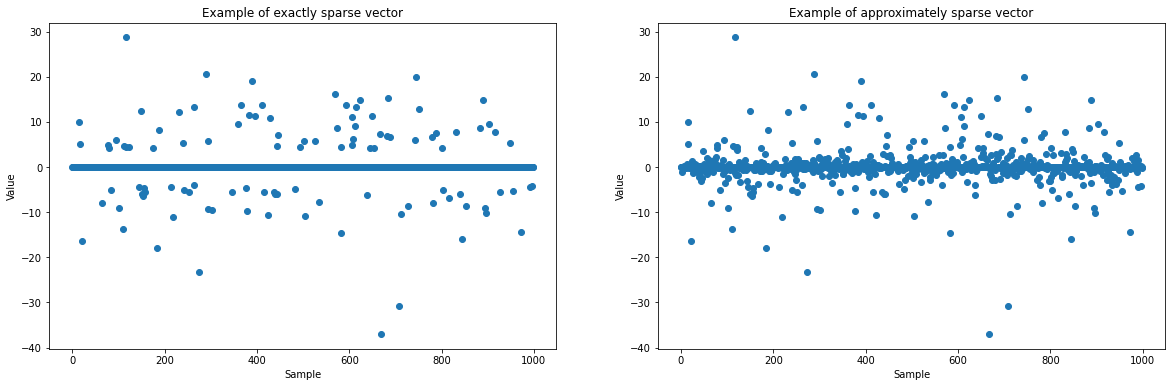

In [ ]:
power = 3
approx_sparse = np.random.randn(1000)**power
exact_sparse = approx_sparse*(np.abs(approx_sparse)>4)

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.plot(exact_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of exactly sparse vector');

fig.add_subplot(1,2,2)
plt.plot(approx_sparse, 'o')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.title('Example of approximately sparse vector');

**1)** What is the difference between an exactly and an approximately sparse signal? Recall the two corresponding definitions.

Exactly sparse signal: Only a small number of the signal k samples have a positive amplitude. 

Approximately sparse signal: Only a small number of the signal k samples have a large amplitude.

**2)** Now let's start to look at some mixtures and to try to geometrically interpret the impact of the mixing.

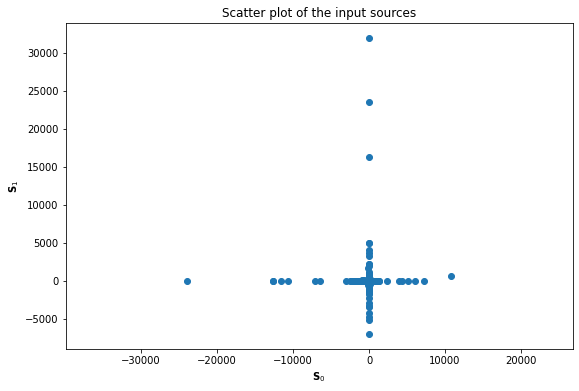

In [ ]:
n = 2         # number of sources
t = 1024      # number of samples
noise_level = 80 # noise level, in dB
power = 9 # power exponent used in the source generation



# TO DO : generate a simulated source S matrix. 
# S will be of dimensions n x t.
# Each of the n sources (i.e. lines of S) will follow the approximately sparse 
# law we used above.
S = np.zeros((n,t)) # TO CHANGE
S[0, :] = np.random.randn(t)**power
S[1, :] = np.random.randn(t)**power

# TO DO : interpret the shape of the scatter plot you obtain
fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of the input sources')
plt.plot(S[0, :], S[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');

In [ ]:
# Here, we generate a mixture matrix (dimensions m x t) from the sources in S  
m = 4         # number of observations

A = np.random.randn(m,n)
X = A@S

noise_level = 120

# To be more realistic, we add some noise to the mixing. 
# Mixtures with SNR > 120 dB can be considered as noiseless for most applications.
if noise_level < 120: 
    #--- Add noise
    N = np.random.randn(m,t)
    N = 10.**(-noise_level/20.)*np.linalg.norm(X)/np.linalg.norm(N)*N
    X = X + N

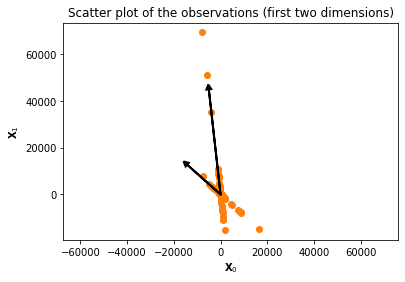

In [ ]:
# TO DO : plot the scatter plot of X. What do you see ? 
# What do the directions of the lines you observe correspond ?
# Try several A matrices, noise_values and powers. Note your comments.

plt.title('Scatter plot of the observations (first two dimensions)')
vrange = 0.25*max(np.sqrt(np.sum(X*X, 0)))
plt.arrow( 0, 0, vrange*A[0, 0], vrange*A[1, 0], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.arrow( 0, 0, vrange*A[0, 1], vrange*A[1, 1], fc="k", ec="k", linewidth=2, head_width=0.1*vrange, head_length=0.1*vrange)
plt.plot(X[0,:], X[1,:], 'C1o', zorder=0)
plt.xlabel("$\mathbf{X}_0$")
plt.ylabel("$\mathbf{X}_1$")
plt.axis('equal');

1. plot the scatter plot of X. What do you see ? 

  I can see it has a star shape and there are 2 flashs.

2. What do the directions of the lines you observe correspond ?

  They correspond to the 2 largest principal directions.

3. Try several A matrices, noise_values and powers. Note your comments.

  If the power is 1, then it doesn't look like star. If the power is large, then it looks like 2 fine flashs.

**II - Performing non-blind source separation**

**1) Data generation**

Before going into blind source separation, in which we want to find physical **A** and **S** matrices such that **X = AS + N**, let us first consider the simpler setting in which we know **A** and want to recover **S**.
We will consider the noisy mixture of two sine signals.

N.B. : unmixing two sinus signal could be done much more easily than using the algorithms we saw during the class. Nevertheless, focusing on such synthetic data enables an easy visualization. The principle readily extend to more complex datasets, such as images.

(-25.0, 25.0)

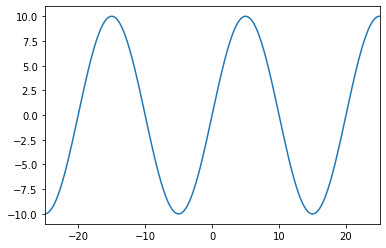

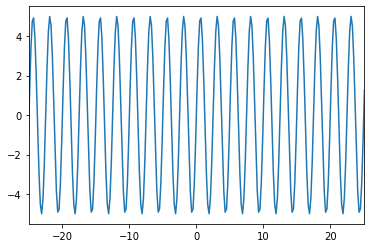

In [ ]:
# Source generation
t = 10000
x_abs = np.linspace(-1000,1000,t)

S = np.zeros((2,t))
S[0,:] = 10*np.sin(2*np.pi*0.05*x_abs)
S[1,:] = 5*np.sin(2*np.pi*0.4*x_abs)

plt.figure(),plt.plot(x_abs,S[0,:])
plt.xlim([-25,25])
plt.figure(),plt.plot(x_abs,S[1,:])
plt.xlim([-25,25])

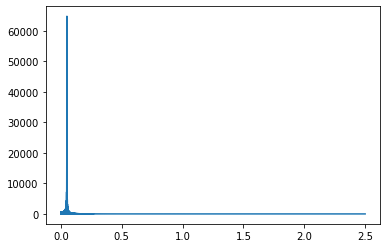

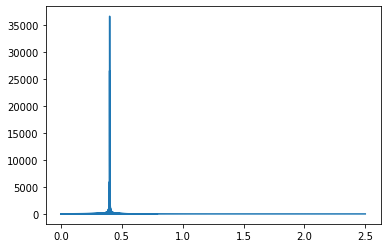

In [ ]:
# Transformation into the DCT domain
Sf = sff.dct(S)
# TO DO : what is the objective of using the DCT?
# TO DO : plot the above DCT and justify what you see? Pay attention to the labeling of the x-axis. Try with sinus of various frequencies.
plt.figure()
plt.plot(np.linspace(0,t/4000,t), np.abs(Sf[0,:]))

plt.figure()
plt.plot(np.linspace(0,t/4000,t), np.abs(Sf[1,:]))


1. what is the objective of using the DCT?

  Similar to DFT, we can transform the signal to frequency domain.

2. plot the above DCT and justify what you see?

  The x values correspond to the frequencies of the 2 signals. 

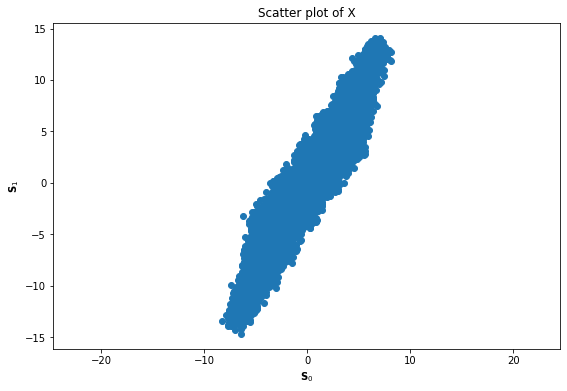

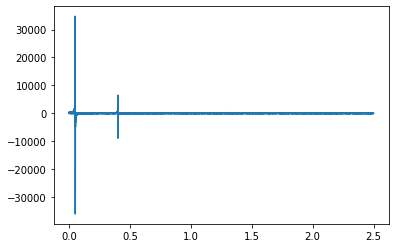

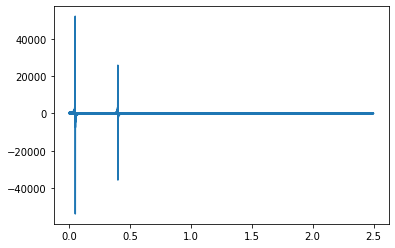

In [ ]:
# Data generation : now, we will create a mixture X = AS + N
A = np.array([[0.5547002 , 0.24253563],
       [0.83205029, 0.9701425 ]]) # You can try other A value, but the columns must have a unitary norm.

X = A@S
X = X + 0.5*np.random.randn(np.shape(X)[0],np.shape(X)[1])# You can try other noise values

# TO DO : plot the mixtures. Explain what you see.
# TO DO : compute the DCT of X. Plot it and explain. Which caracteristic of the DCT will we use to recover the sources?

fig = plt.figure(figsize=(20, 6))
fig.add_subplot(1,2,1)
plt.title('Scatter plot of X')
plt.plot(X[0, :], X[1, :], 'C0o')
plt.xlabel("$\mathbf{S}_0$")
plt.ylabel("$\mathbf{S}_1$")
plt.axis('equal');


Xf = sff.dct(X)

plt.figure()
plt.plot(np.linspace(0,t/4000,t), Xf[0,:])

plt.figure()
plt.plot(np.linspace(0,t/4000,t), Xf[1,:])

1. plot the mixtures. Explain what you see.
  
  This time, with mixing function, we can no longer seperate the 2 signals from the mixture plot.

2. compute the DCT of X. Plot it and explain. Which caracteristic of the DCT will we use to recover the sources?

  The signal in frequency domain has 2 separate pics, this corresponds to the 2  input signals. We can also calculate the amplitude of the 2 signals from the plot of DCT, so we can well recover the sources.

**2) Source separation**

Now that we generated observations from simulated sources, we will focus on the source separation problem: recovering the sources from the observations (and the knowledge of A, since we are here in the non-blind setting).

To do that, we propose here to solve the source separation problem using a sparsity constraint on the sources. The cost function will then be minimized using the ISTA algorithm.

**2-1)** First, write the cost function we want to minimize to perform non-blind sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?


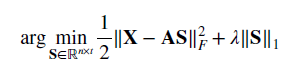




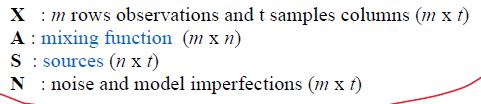

The L1 norm is not smooth.

The cost function is convex.

**2-2)** Compute the gradient along the S variable of the data-fidelity term.

Just directly calculate it

$\nabla f(\mathrm{S}) = -\mathrm{A}^T(\mathrm{A}\mathrm{S}-\mathrm{X})$

**2-3)**

Recall what the proximal operator of the l1-norm is.

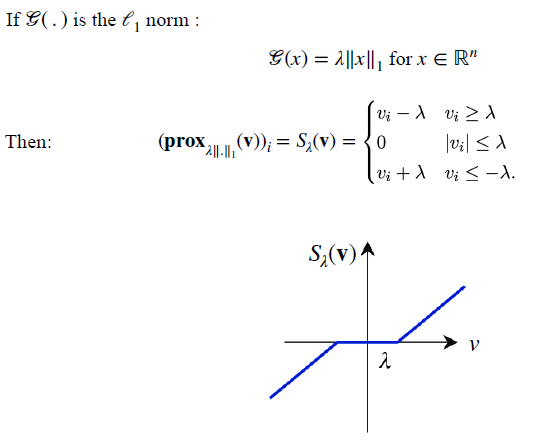

In [ ]:
# TO DO: implement the proximal operator of the l1-norm in the above function:
def prox_l1(S_est,thrd):
  # To complete
  S_est = (np.abs(S_est)>=thrd)*(S_est - thrd*((S_est>=thrd)*2-1)) 
  return S_est



**2-4)** In your report, explain the main idea of the ISTA algorithm. Then, implement it.

The main idea is gradient descent, however, here the L1 norm is not differentiable in some points, so we have to use proximal gradient method.

In [ ]:
# TO DO: implement the ISTA algorithm to minimize the cost function you wrote in question II-2-1.
def ISTA(X,A = np.eye(2),n=2,lamb=0,nbIt = 100):
   gamma = 0.9/np.sum(A.T @ A)
   S_est = np.zeros((A.shape[1], X.shape[1])) 
   i = 1
   while i<nbIt:
     S_est = prox_l1(S_est - gamma*A.T@(A@S_est - X), lamb)
     i += 1
   return S_est

**2-5)** It's now time to play with the code : launch the ISTA algorithm and look at the results.

In [ ]:
S_estf = ISTA(Xf,A = A,n=2,lamb=100,nbIt = 1000)# TO DO : try various lamb values. What is the minimum value you should no go below? What is the issue with choosing too big values?



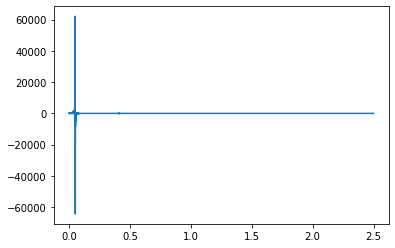

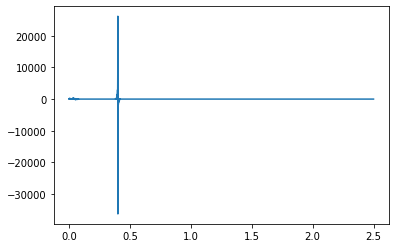

In [ ]:
# Plot the estimated sources in the DCT domain. What kind of sparsity to they exhibit? Why?
plt.figure()
plt.plot(np.linspace(0,t/4000,t), S_estf[0,:])

plt.figure()
plt.plot(np.linspace(0,t/4000,t), S_estf[1,:])

1. What is the minimum value you should no go below? 

  I think 100 is the minimum value, otherwises, there are many non-zero values.
2. What is the issue with choosing too big values?

  If we choose a very big values, then it's over regularized, then the data-fidelity term is not well fitted.
3. What kind of sparsity to they exhibit? Why?

  Exactly sparsity, because the l1 norm can do as feature selection, so many values are set to 0.

**2-6)** Transform the sources back in the direct domain. What do you see? Conclude.

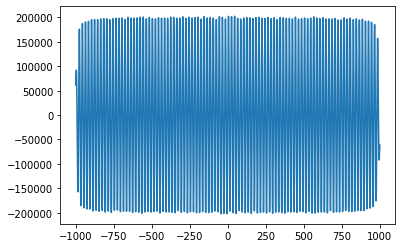

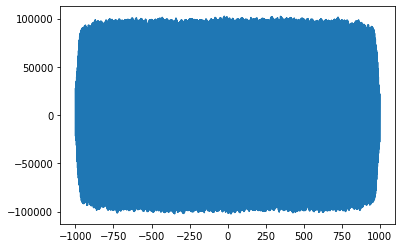

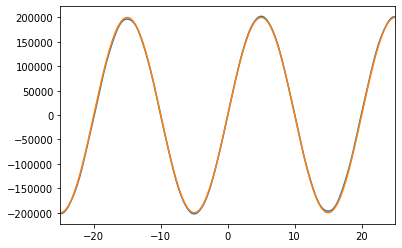

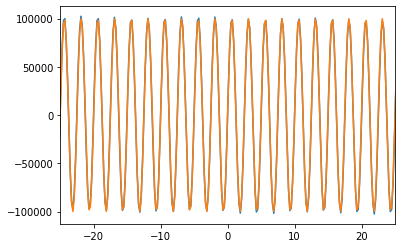

In [ ]:
# TO DO : transform the estimated sources in the direct domain? Plot them. Explain the differences with the original sources you observe.
S_est1 = sff.idct(S_estf)
plt.figure(),plt.plot(x_abs,S_est1[0,:])
# plt.xlim([-25,25])
plt.figure(),plt.plot(x_abs,S_est1[1,:])
# plt.xlim([-25,25])

# TO DO : compare the central parts of the original and estimated sources.
# CORRECTION : denoising : even with relatively high noise levels, the sources are quite well denoised.

plt.figure()
plt.plot(x_abs,S_est1[0,:])
plt.plot(x_abs,S[0,:]*2*t)
plt.xlim([-25,25])
plt.show()
plt.figure(),
plt.plot(x_abs,S_est1[1,:])
plt.plot(x_abs,S[1,:]*2*t)
plt.xlim([-25,25])
plt.show()

**III - Blind Source Separation : PALM**

Let's now delve into the core problem : *blind* source separation, in which **A** is unknown. To leverage sparsity, we will use the PALM algorithm.

Thoughout this whole section, we will re-use the same synthetic data as above (i.e., the one generated in II-1).

1) Write the cost function we want to minimize to perform *blind* sparse source separation. Explain each term (in particular, which one is smooth or not). Is this cost function convex?




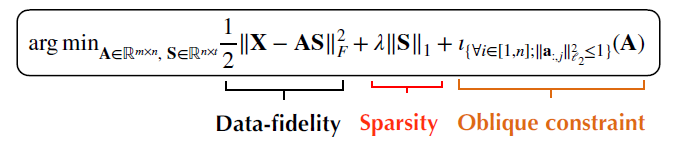

Because of L1 norm of S, it's not smooth.

This cost function is not convex.

2) Recall what the gradient of the data fidelity term over A is.


-(X-AS)S^T

3) Compte the proximal operator of the oblique constraint. Implement it.

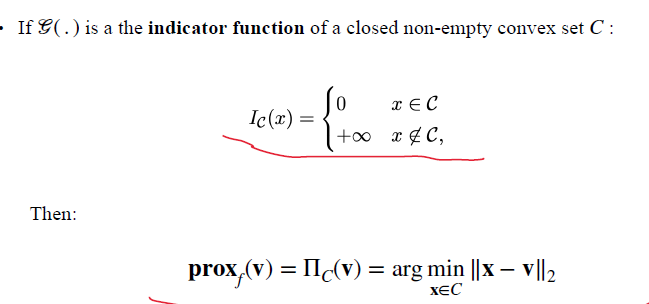

In this case, the convex set C is the set where the norm of each colomn of x is 1. So we just have to scale the input

In [ ]:
def prox_oblique(A):
  # TO DO 
  A = A / (1e-6+np.sqrt(np.sum(A**2, axis=0)))
  return A

4) Implement the PALM algorithm to minimize the cost function you wrote in III-1).

In [ ]:
def PALM(X,n=2,lamb=0,nbIt = 100):
   
   # TO DO
   A_est = np.random.rand(X.shape[0], n) #/ (1e-6+np.sum(A_est@A_est.T, axis=0))
   #A_est = A
   S_est = np.zeros((n, X.shape[1]))  #(np.random.rand(n, X.shape[1])>0.7)
   for i in range(nbIt):
    #  print(i, np.max(S_est))
     S_est = prox_l1(S_est + (0.9/(1e-6 + np.sum(A_est.T @ A_est))) * (A_est.T @ (X-(A_est@S_est))), lamb)
     A_est = prox_oblique(A_est + 0.9/(1e-6+np.sum(S_est@S_est.T))* (X-A_est @ S_est) @ S_est.T)  
      
   return A_est,S_est

5) Launch the PALM algorithm to retrieve both A and S from X. Plot your results. How good is the separation? The separation quality is usually well evaluated comparing the true and estimated A matrices.

The separation is very good

In [ ]:
A_est, S_estf = PALM(Xf,n=2,lamb=1000,nbIt = 1000)

In [ ]:
print(A)
print(A_est)

[[0.5547002  0.24253563]
 [0.83205029 0.9701425 ]]
[[0.55537378 0.24427862]
 [0.83159973 0.96970408]]


In [ ]:
print(np.max(S_estf))

58220.85087960483


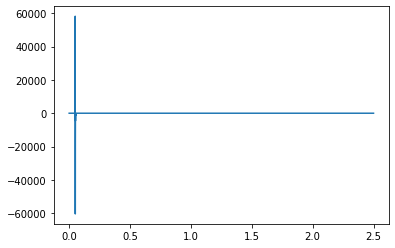

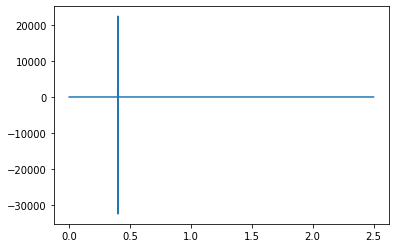

In [ ]:
plt.figure()
plt.plot(np.linspace(0,t/4000,t), S_estf[0,:])

plt.figure()
plt.plot(np.linspace(0,t/4000,t), S_estf[1,:])

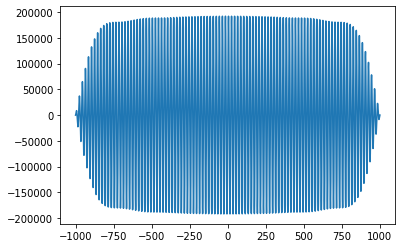

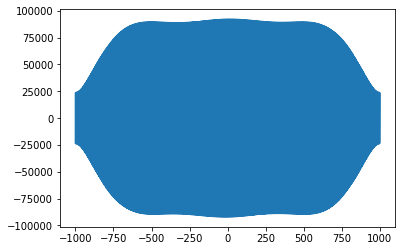

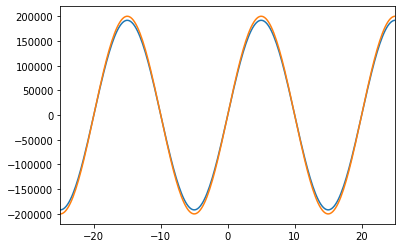

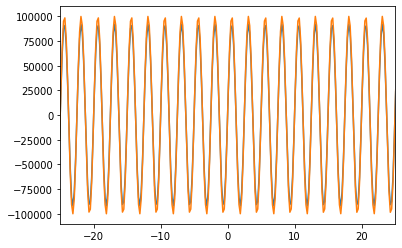

In [ ]:
S_est1 = sff.idct(S_estf)
plt.figure(),plt.plot(x_abs,S_est1[0,:])
# plt.xlim([-25,25])
plt.figure(),plt.plot(x_abs,S_est1[1,:])
# plt.xlim([-25,25])

plt.figure()
plt.plot(x_abs,S_est1[0,:])
plt.plot(x_abs,S[0,:]*2*t)
plt.xlim([-25,25])
plt.show()
plt.figure(),
plt.plot(x_abs,S_est1[1,:])
plt.plot(x_abs,S[1,:]*2*t)
plt.xlim([-25,25])
plt.show()